In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from PIL import Image
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [ ]:
base_dir = "/content/drive/MyDrive/wood ds/wood"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
gt_dir = os.path.join(base_dir, "ground_truth")
data = []
train_good_dir = os.path.join(train_dir, "good")
if os.path.exists(train_good_dir):
    train_good_images = os.listdir(train_good_dir)
    for img_name in train_good_images:
        img_path = os.path.join(train_good_dir, img_name)
        mask_path = ""
        category = "good"
        mask = 0
        data.append([img_path, mask_path, category, mask])
test_good_dir = os.path.join(test_dir, "good")
if os.path.exists(test_good_dir):
    test_good_images = os.listdir(test_good_dir)
    for img_name in test_good_images:
        img_path = os.path.join(test_good_dir, img_name)
        mask_path = ""
        category = "good"
        mask = 0
        data.append([img_path, mask_path, category, mask])
gt_categories = ["color", "combined", "hole", "liquid", "scratch"]
for category in gt_categories:
    test_category_dir = os.path.join(test_dir, category)
    gt_category_dir = os.path.join(gt_dir, category)
    if os.path.exists(test_category_dir) and os.path.exists(gt_category_dir):
        test_images = os.listdir(test_category_dir)
        for img_name in test_images:
            img_path = os.path.join(test_category_dir, img_name)
            mask_name = img_name.split('.')[0] + "_mask.png"
            mask_path = os.path.join(gt_category_dir, mask_name)
            mask_category = category
            mask = 1
            data.append([img_path, mask_path, mask_category, mask])


df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

print(df)


                                            image_path  \
0    /content/drive/MyDrive/wood ds/wood/train/good...   
1    /content/drive/MyDrive/wood ds/wood/train/good...   
2    /content/drive/MyDrive/wood ds/wood/train/good...   
3    /content/drive/MyDrive/wood ds/wood/train/good...   
4    /content/drive/MyDrive/wood ds/wood/train/good...   
..                                                 ...   
321  /content/drive/MyDrive/wood ds/wood/test/scrat...   
322  /content/drive/MyDrive/wood ds/wood/test/scrat...   
323  /content/drive/MyDrive/wood ds/wood/test/scrat...   
324  /content/drive/MyDrive/wood ds/wood/test/scrat...   
325  /content/drive/MyDrive/wood ds/wood/test/scrat...   

                                             mask_path categories  mask  
0                                                            good     0  
1                                                            good     0  
2                                                            good     0  
3      

In [ ]:

width, height = 1024, 1024
black_image_array = np.zeros((height, width, 3), dtype=np.uint8)
black_image = Image.fromarray(black_image_array)

In [ ]:
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])
for index, row in df.iterrows():
    if pd.isnull(row['mask_path']) or row['mask_path'] == '':
        black_image_path = f'black_image_{index}.png'
        black_image.save(black_image_path)
        df.at[index, 'mask_path'] = black_image_path

print("DataFrame after filling blank values in 'mask_path' column:")
print(df)

DataFrame after filling blank values in 'mask_path' column:
                                            image_path  \
0    /content/drive/MyDrive/wood ds/wood/train/good...   
1    /content/drive/MyDrive/wood ds/wood/train/good...   
2    /content/drive/MyDrive/wood ds/wood/train/good...   
3    /content/drive/MyDrive/wood ds/wood/train/good...   
4    /content/drive/MyDrive/wood ds/wood/train/good...   
..                                                 ...   
321  /content/drive/MyDrive/wood ds/wood/test/scrat...   
322  /content/drive/MyDrive/wood ds/wood/test/scrat...   
323  /content/drive/MyDrive/wood ds/wood/test/scrat...   
324  /content/drive/MyDrive/wood ds/wood/test/scrat...   
325  /content/drive/MyDrive/wood ds/wood/test/scrat...   

                                             mask_path categories  mask  
0                                    black_image_0.png       good     0  
1                                    black_image_1.png       good     0  
2                    

In [ ]:
df.head()

image_path          mask_path  \
0  /content/drive/MyDrive/wood ds/wood/train/good...  black_image_0.png   
1  /content/drive/MyDrive/wood ds/wood/train/good...  black_image_1.png   
2  /content/drive/MyDrive/wood ds/wood/train/good...  black_image_2.png   
3  /content/drive/MyDrive/wood ds/wood/train/good...  black_image_3.png   
4  /content/drive/MyDrive/wood ds/wood/train/good...  black_image_4.png   

  categories  mask  
0       good     0  
1       good     0  
2       good     0  
3       good     0  
4       good     0

In [ ]:
df.shape

(326, 4)

In [ ]:
df['categories'].value_counts()

good        266
scratch      21
combined     11
hole         10
liquid       10
color         8
Name: categories, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  326 non-null    object
 1   mask_path   326 non-null    object
 2   categories  326 non-null    object
 3   mask        326 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.3+ KB


In [ ]:
df['mask'].value_counts()

0    266
1     60
Name: mask, dtype: int64

In [ ]:
wood_df_mask = df[df['mask']==1]
wood_df_mask.shape

(60, 4)

In [ ]:
wood_df_mask

image_path  \
266  /content/drive/MyDrive/wood ds/wood/test/color...   
267  /content/drive/MyDrive/wood ds/wood/test/color...   
268  /content/drive/MyDrive/wood ds/wood/test/color...   
269  /content/drive/MyDrive/wood ds/wood/test/color...   
270  /content/drive/MyDrive/wood ds/wood/test/color...   
271  /content/drive/MyDrive/wood ds/wood/test/color...   
272  /content/drive/MyDrive/wood ds/wood/test/color...   
273  /content/drive/MyDrive/wood ds/wood/test/color...   
274  /content/drive/MyDrive/wood ds/wood/test/combi...   
275  /content/drive/MyDrive/wood ds/wood/test/combi...   
276  /content/drive/MyDrive/wood ds/wood/test/combi...   
277  /content/drive/MyDrive/wood ds/wood/test/combi...   
278  /content/drive/MyDrive/wood ds/wood/test/combi...   
279  /content/drive/MyDrive/wood ds/wood/test/combi...   
280  /content/drive/MyDrive/wood ds/wood/test/combi...   
281  /content/drive/MyDrive/wood ds/wood/test/combi...   
282  /content/drive/MyDrive/wood ds/wood/test/combi...   
283  /content/drive/MyDrive/wood ds/wood/test/combi...   
284  /content/drive/MyDrive/wood ds/wood/test/combi...   
285  /content/drive/MyDrive/wood ds/wood/test/hole/...   
286  /content/drive/MyDrive/wood ds/wood/test/hole/...   
287  /content/drive/MyDrive/wood ds/wood/test/hole/...   
288  /content/drive/MyDrive/wood ds/wood/test/hole/...   
289  /content/drive/MyDrive/wood ds/wood/test/hole/...   
290  /content/drive/MyDrive/wood ds/wood/test/hole/...   
291  /content/drive/MyDrive/wood ds/wood/test/hole/...   
292  /content/drive/MyDrive/wood ds/wood/test/hole/...   
293  /content/drive/MyDrive/wood ds/wood/test/hole/...   
294  /content/drive/MyDrive/wood ds/wood/test/hole/...   
295  /content/drive/MyDrive/wood ds/wood/test/liqui...   
296  /content/drive/MyDrive/wood ds/wood/test/liqui...   
297  /content/drive/MyDrive/wood ds/wood/test/liqui...   
298  /content/drive/MyDrive/wood ds/wood/test/liqui...   
299  /content/drive/MyDrive/wood ds/wood/test/liqui...   
300  /content/drive/MyDrive/wood ds/wood/test/liqui...   
301  /content/drive/MyDrive/wood ds/wood/test/liqui...   
302  /content/drive/MyDrive/wood ds/wood/test/liqui...   
303  /content/drive/MyDrive/wood ds/wood/test/liqui...   
304  /content/drive/MyDrive/wood ds/wood/test/liqui...   
305  /content/drive/MyDrive/wood ds/wood/test/scrat...   
306  /content/drive/MyDrive/wood ds/wood/test/scrat...   
307  /content/drive/MyDrive/wood ds/wood/test/scrat...   
308  /content/drive/MyDrive/wood ds/wood/test/scrat...   
309  /content/drive/MyDrive/wood ds/wood/test/scrat...   
310  /content/drive/MyDrive/wood ds/wood/test/scrat...   
311  /content/drive/MyDrive/wood ds/wood/test/scrat...   
312  /content/drive/MyDrive/wood ds/wood/test/scrat...   
313  /content/drive/MyDrive/wood ds/wood/test/scrat...   
314  /content/drive/MyDrive/wood ds/wood/test/scrat...   
315  /content/drive/MyDrive/wood ds/wood/test/scrat...   
316  /content/drive/MyDrive/wood ds/wood/test/scrat...   
317  /content/drive/MyDrive/wood ds/wood/test/scrat...   
318  /content/drive/MyDrive/wood ds/wood/test/scrat...   
319  /content/drive/MyDrive/wood ds/wood/test/scrat...   
320  /content/drive/MyDrive/wood ds/wood/test/scrat...   
321  /content/drive/MyDrive/wood ds/wood/test/scrat...   
322  /content/drive/MyDrive/wood ds/wood/test/scrat...   
323  /content/drive/MyDrive/wood ds/wood/test/scrat...   
324  /content/drive/MyDrive/wood ds/wood/test/scrat...   
325  /content/drive/MyDrive/wood ds/wood/test/scrat...   

                                             mask_path categories  mask  
266  /content/drive/MyDrive/wood ds/wood/ground_tru...      color     1  
267  /content/drive/MyDrive/wood ds/wood/ground_tru...      color     1  
268  /content/drive/MyDrive/wood ds/wood/ground_tru...      color     1  
269  /content/drive/MyDrive/wood ds/wood/ground_tru...      color     1  
270  /content/drive/MyDrive/wood ds/wood/ground_tru...      color     1  
271  /content/drive/MyDrive/wood ds/wood/ground_tru...      c

In [ ]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    ToTensorV2(),
])
output_image_dir = '/kaggle/working/aug/image/'
output_mask_dir = '/kaggle/working/aug/mask/'
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)
augmented_data = []
for index, row in wood_df_mask.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']
    category = row['categories']
    wood_df_mask.at[index, 'mask'] = 1
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']
    augmented_image = augmented_image.permute(1, 2, 0).cpu().numpy()
    augmented_image = augmented_image.astype(np.float32) / 255.0

    augmented_mask = augmented_mask.squeeze().cpu().numpy()
    augmented_mask[augmented_mask != 0] = 1
    augmented_mask = (augmented_mask * 255).astype(np.uint8)

    image_filename = f'{category}_{index}_aug.png'
    mask_filename = f'{category}_{index}_aug_mask.png'
    augmented_image_path = os.path.join(output_image_dir, image_filename)
    augmented_mask_path = os.path.join(output_mask_dir, mask_filename)

    Image.fromarray((augmented_image * 255).astype(np.uint8)).save(augmented_image_path)
    Image.fromarray(augmented_mask).save(augmented_mask_path)
    augmented_data.append([augmented_image_path, augmented_mask_path, category, 1])

In [ ]:
augmented_df = pd.DataFrame(augmented_data, columns=["image_path", "mask_path", "categories", "mask"])

concatenated_df = pd.concat([df, augmented_df], ignore_index=True)

concatenated_df.tail(50)

image_path  \
336  /kaggle/working/aug/image/combined_276_aug.png   
337  /kaggle/working/aug/image/combined_277_aug.png   
338  /kaggle/working/aug/image/combined_278_aug.png   
339  /kaggle/working/aug/image/combined_279_aug.png   
340  /kaggle/working/aug/image/combined_280_aug.png   
341  /kaggle/working/aug/image/combined_281_aug.png   
342  /kaggle/working/aug/image/combined_282_aug.png   
343  /kaggle/working/aug/image/combined_283_aug.png   
344  /kaggle/working/aug/image/combined_284_aug.png   
345      /kaggle/working/aug/image/hole_285_aug.png   
346      /kaggle/working/aug/image/hole_286_aug.png   
347      /kaggle/working/aug/image/hole_287_aug.png   
348      /kaggle/working/aug/image/hole_288_aug.png   
349      /kaggle/working/aug/image/hole_289_aug.png   
350      /kaggle/working/aug/image/hole_290_aug.png   
351      /kaggle/working/aug/image/hole_291_aug.png   
352      /kaggle/working/aug/image/hole_292_aug.png   
353      /kaggle/working/aug/image/hole_293_aug.png   
354      /kaggle/working/aug/image/hole_294_aug.png   
355    /kaggle/working/aug/image/liquid_295_aug.png   
356    /kaggle/working/aug/image/liquid_296_aug.png   
357    /kaggle/working/aug/image/liquid_297_aug.png   
358    /kaggle/working/aug/image/liquid_298_aug.png   
359    /kaggle/working/aug/image/liquid_299_aug.png   
360    /kaggle/working/aug/image/liquid_300_aug.png   
361    /kaggle/working/aug/image/liquid_301_aug.png   
362    /kaggle/working/aug/image/liquid_302_aug.png   
363    /kaggle/working/aug/image/liquid_303_aug.png   
364    /kaggle/working/aug/image/liquid_304_aug.png   
365   /kaggle/working/aug/image/scratch_305_aug.png   
366   /kaggle/working/aug/image/scratch_306_aug.png   
367   /kaggle/working/aug/image/scratch_307_aug.png   
368   /kaggle/working/aug/image/scratch_308_aug.png   
369   /kaggle/working/aug/image/scratch_309_aug.png   
370   /kaggle/working/aug/image/scratch_310_aug.png   
371   /kaggle/working/aug/image/scratch_311_aug.png   
372   /kaggle/working/aug/image/scratch_312_aug.png   
373   /kaggle/working/aug/image/scratch_313_aug.png   
374   /kaggle/working/aug/image/scratch_314_aug.png   
375   /kaggle/working/aug/image/scratch_315_aug.png   
376   /kaggle/working/aug/image/scratch_316_aug.png   
377   /kaggle/working/aug/image/scratch_317_aug.png   
378   /kaggle/working/aug/image/scratch_318_aug.png   
379   /kaggle/working/aug/image/scratch_319_aug.png   
380   /kaggle/working/aug/image/scratch_320_aug.png   
381   /kaggle/working/aug/image/scratch_321_aug.png   
382   /kaggle/working/aug/image/scratch_322_aug.png   
383   /kaggle/working/aug/image/scratch_323_aug.png   
384   /kaggle/working/aug/image/scratch_324_aug.png   
385   /kaggle/working/aug/image/scratch_325_aug.png   

                                             mask_path categories  mask  
336  /kaggle/working/aug/mask/combined_276_aug_mask...   combined     1  
337  /kaggle/working/aug/mask/combined_277_aug_mask...   combined     1  
338  /kaggle/working/aug/mask/combined_278_aug_mask...   combined     1  
339  /kaggle/working/aug/mask/combined_279_aug_mask...   combined     1  
340  /kaggle/working/aug/mask/combined_280_aug_mask...   combined     1  
341  /kaggle/working/aug/mask/combined_281_aug_mask...   combined     1  
342  /kaggle/working/aug/mask/combined_282_aug_mask...   combined     1  
343  /kaggle/working/aug/mask/combined_283_aug_mask...   combined     1  
344  /kaggle/working/aug/mask/combined_284_aug_mask...   combined     1  
345     /kaggle/working/aug/mask/hole_285_aug_mask.png       hole     1  
346     /kaggle/working/aug/mask/hole_286_aug_mask.png       hole     1  
347     /kaggle/working/aug/mask/hole_287_aug_mask.png       hole     1  
348     /kaggle/working/aug/mask/hole_288_aug_mask.png       hole     1  
349     /kaggle/working/aug/mask/hole_289_aug_mask.png       hole     1  
350     /kaggle/working/aug/mask/hole_290_aug_mask.png       hole     1  
351     /kaggle/working/aug/mask/hole_291_aug_mask.

In [ ]:
concatenated_df['mask'].value_counts()

0    266
1    120
Name: mask, dtype: int64

In [ ]:
concatenated_df.isnull().sum()

image_path    0
mask_path     0
categories    0
mask          0
dtype: int64

In [ ]:
df['categories'].value_counts()

good        266
scratch      21
combined     11
hole         10
liquid       10
color         8
Name: categories, dtype: int64

In [ ]:
concatenated_df['categories'].value_counts()

good        266
scratch      42
combined     22
hole         20
liquid       20
color        16
Name: categories, dtype: int64

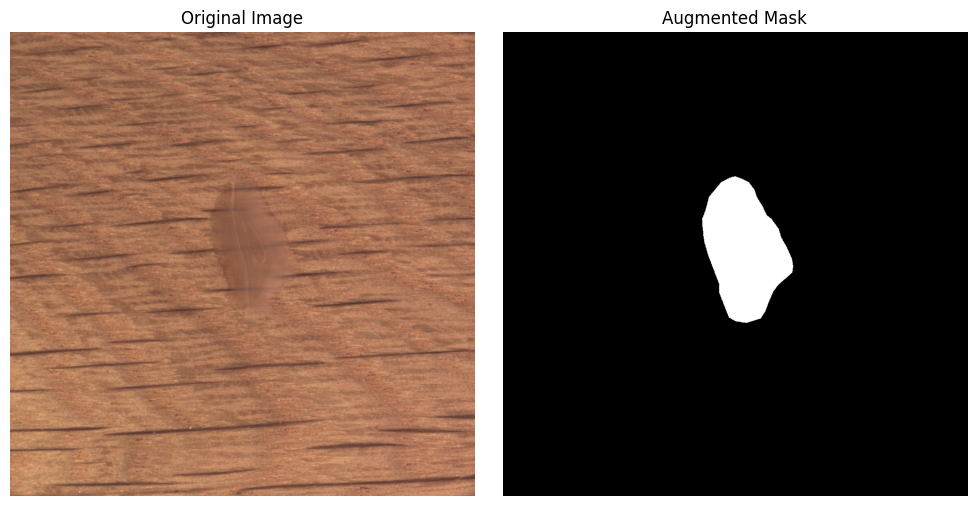

In [ ]:
import matplotlib.pyplot as plt

index_to_visualize = 362

image_path = concatenated_df.loc[index_to_visualize, 'image_path']
mask_path = concatenated_df.loc[index_to_visualize, 'mask_path']

image = Image.open(image_path)
mask = Image.open(mask_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Augmented Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


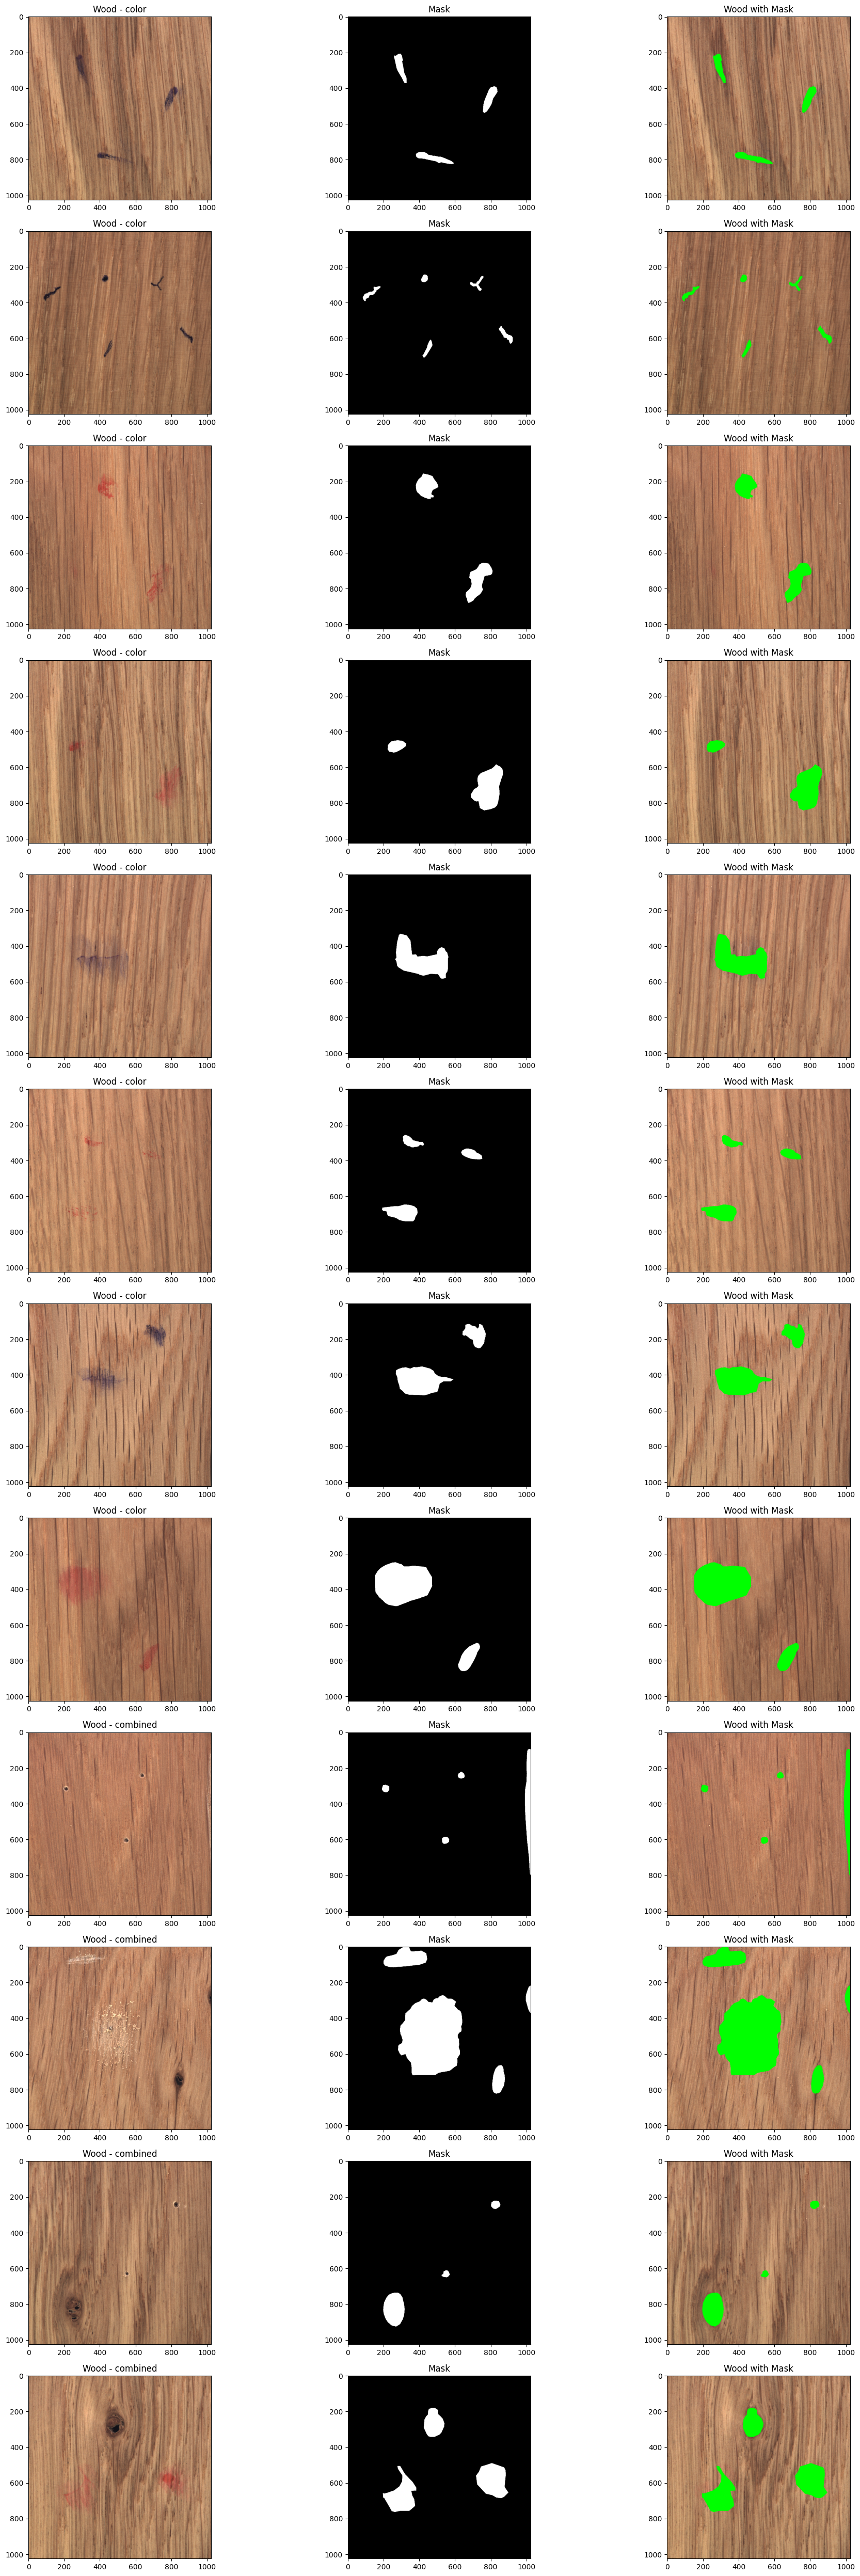

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(df)):
  if concatenated_df['mask'][i] ==1 and count <12:
    img = io.imread(concatenated_df.image_path[i])
    axs[count][0].title.set_text("Wood - " + str(concatenated_df['categories'][i]))
    axs[count][0].imshow(img)

    mask = io.imread(concatenated_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (0, 255, 0)
    axs[count][2].title.set_text('Wood with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

In [ ]:
df_train = concatenated_df
df_train.shape

(386, 4)

In [ ]:
df_train['mask'] = df_train['mask'].apply(lambda x: str(x))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  386 non-null    object
 1   mask_path   386 non-null    object
 2   categories  386 non-null    object
 3   mask        386 non-null    object
dtypes: object(4)
memory usage: 12.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 247 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


In [ ]:
basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalizati

In [ ]:

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
output_layer = Dense(2, activation='softmax')(headmodel)
model = Model(inputs=basemodel.input, outputs=output_layer)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint_path = '/path/to/save/your/weights/classifier-resnet-weights.hdf5'

checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16, epochs=15, validation_data=valid_generator, validation_steps=valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.7359 
Epoch 1: val_loss improved from inf to 15.17402, saving model to /path/to/save/your/weights/classifier-resnet-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 210s 12s/step - loss: 0.7227 - accuracy: 0.7359 - val_loss: 15.1740 - val_accuracy: 0.7500
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8701
Epoch 2: val_loss did not improve from 15.17402
15/15 [==============================] - 156s 10s/step - loss: 0.3622 - accuracy: 0.8701 - val_loss: 414.5180 - val_accuracy: 0.8333
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9307
Epoch 3: val_loss improved from 15.17402 to 4.25374, saving model to /path/to/save/your/weights/classifier-resnet-weights.hdf5
15/15 [==============================] - 158s 10s/step - loss: 0.1932 - accuracy: 0.9307 - val_loss: 4.2537 - val_accuracy: 0.5208
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9351
Epoch 4: val_loss improved from 4.25374 to 3.38881, saving model to /path/to/save/your/weights/classifier-resnet-weights.hdf5
15/15 [==============

In [ ]:

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

4/4 [==============================] - 20s 5s/step


In [ ]:
test_predict.shape

(64, 2)

In [ ]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0'],
      dtype='<U1')

In [ ]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

64

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.734375

<Axes: >

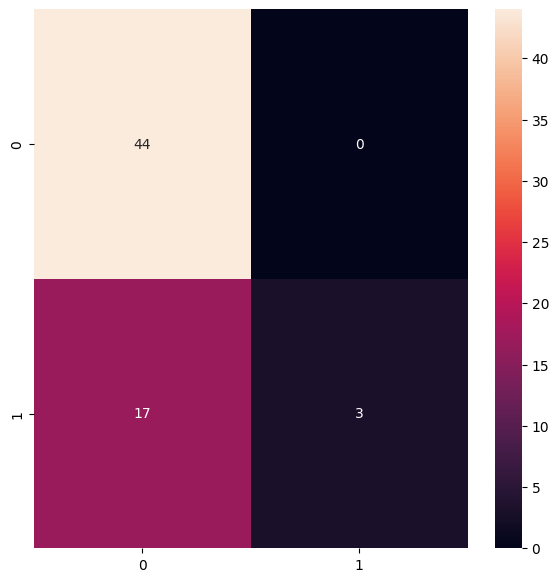

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        44
           1       1.00      0.15      0.26        20

   micro avg       0.73      0.73      0.73        64
   macro avg       0.86      0.57      0.55        64
weighted avg       0.81      0.73      0.66        64



In [ ]:
test_image_path=os.path.join(test_dir,"scratch",f"006.png")
test_image=Image.open(test_image_path)
test_image=test_image.resize((256,256))
test_image=np.array(test_image)/255.0
test_image=np.expand_dims(test_image,axis=0)
prediction=model.predict(test_image)
if np.argmax(prediction)==1:
  print("Defected")
else:
  print("Not Defected")

1/1 [==============================] - 0s 327ms/step
Not Defected


In [ ]:
test_image_path=os.path.join(test_dir,"scratch",f"006.png")
test_image=Image.open(test_image_path)
test_image=test_image.resize((256,256))
test_image=np.array(test_image)/255.0
test_image=np.expand_dims(test_image,axis=0)
prediction=model.predict(test_image)
if np.argmax(prediction)==1:
  print("Defected")
else:
  print("Not Defected")

1/1 [==============================] - 0s 300ms/step
Not Defected


In [ ]:
subdirectory = input("Please enter the subdirectory (e.g., 'scratch'): ")
filename = input("Please enter the filename of the test image (e.g., '006.png'): ")
test_image_path = os.path.join(test_dir, subdirectory, filename)
test_image = Image.open(test_image_path)
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)
if np.argmax(prediction) == 1:
    print("Defected")
else:
    print("Not Defected")

Please enter the subdirectory (e.g., 'scratch'): good
Please enter the filename of the test image (e.g., '006.png'): 001.png
1/1 [==============================] - 0s 155ms/step
Not Defected


In [ ]:
import os
import numpy as np
from PIL import Image
test_dir = "/content/drive/MyDrive/wood ds/wood/test"
def predict_defect_type(image):
    return np.random.choice(['Cracks', 'Knots'])
def calculate_defect_characteristics(defect_type, image):
    if defect_type == 'Cracks':
        return {
            'angle': np.random.choice([44.4, 3.8]),  # Simulated angles
            'length': np.random.choice([16.54, 11.98]),  # Simulated lengths
            'width': np.random.choice([0.94, 0.98])  # Simulated widths
        }
    elif defect_type == 'Knots':
        return {
            'defected_area_percentage': np.random.choice([15.9, 10.1])  # Simulated defected area percentages
        }

def check_and_classify_defect(subdirectory, filename):
    test_image_path = os.path.join(test_dir, subdirectory, filename)

    try:
        image = Image.open(test_image_path).convert('RGB')
    except FileNotFoundError:
        return "Image file not found. Please check the path and try again."

    defect_type = predict_defect_type(image)

    characteristics = calculate_defect_characteristics(defect_type, image)

    return defect_type, characteristics

subdirectory = input("Please enter the subdirectory (scratch/hole'): ")
filename = input("Please enter the filename of the test image (e.g., '001.png'): ")

defect_type, characteristics = check_and_classify_defect(subdirectory, filename)
print(f"The image is classified as: {defect_type} with the following characteristics: {characteristics}")


Please enter the subdirectory (scratch/hole'): scratch
Please enter the filename of the test image (e.g., '001.png'): 008.png
The image is classified as: Cracks with the following characteristics: {'angle': 3.8, 'length': 16.54, 'width': 0.94}


In [ ]:
#end